# Voice Classification

### Read V100 Dataset

In [1]:
import pandas as pd
data = pd.read_csv('ML_dataset_without_firm_info.csv')

In [2]:
print data.columns

Index([u'Unnamed: 0', u'filename', u'voice_type', u'Text_converted',
       u'key_pattern_1', u'key_pattern_2', u'key_pattern_3', u'key_pattern_4',
       u'key_pattern_5', u'key_pattern_6', u'key_pattern_7', u'key_pattern_8',
       u'key_pattern_9', u'key_pattern_10', u'key_pattern_11',
       u'key_pattern_12', u'reached', u'office', u'take', u'voicemail',
       u'please', u'leave', u'message', u'hello', u'away', u'hi', u'available',
       u'sorry', u'unable', u'often', u'now', u'currently', u'get',
       u'recorded', u'time', u'return', u'method', u'recall', u'desk',
       u'preach', u'name', u'phone', u'thank', u'one', u'think', u'got',
       u'freak', u'missed', u'mailbox', u'either', u'no_of_word',
       u'exist_last_name', u'exist_first_name', u'j', u'okay', u'forwarded',
       u'messaging', u'system', u'met', u'cared', u'god', u'great', u'another',
       u'map', u'firm', u'eight', u'table', u'dc', u'k', u'lawyer_male',
       u'max', u'min', u'mean', u'median', u'q1', 

### Add manual classification to previous training set

In [2]:
df1 = pd.read_csv('ML_without_firm_dataset_with_type_0812.csv')
print(df1.shape)
df2 = pd.read_csv('additional_train_all_infor_0813.csv')
print(df2.shape)


(1787, 79)
(1800, 79)


In [3]:
total_data = data.append([df1,df2],ignore_index=True)
total_data = total_data[data.columns]
data = total_data
print(data.shape)

(5858, 79)


### Preprocessing the training data

In [4]:
print(len(data[data['voice_type'] == 1]))
print(len(data[data['voice_type'] == 0]))
print(len(data[data['voice_type'] == 2]))

# Convert to binary:
data.loc[data["voice_type"] == 2, "voice_type"] = 0

print(len(data[data['voice_type'] == 1]))
print(len(data[data['voice_type'] == 0]))
# Type 1 : Non-type 1 = 1.3:1

# Convert to float
acoustics = ["max", 'min', 'mean', 'median', 'q1', 'q3', 'stdev', 'min_intensity']
for item in acoustics:
    data[item] = data[item].apply(pd.to_numeric, errors='coerce', downcast='float')


3343
1221
1294
3343
2515


### Split the data into training and testing subsets, set seed to be 2333

In [5]:
from sklearn.model_selection import train_test_split

X = data[data.columns[4:]]
y = data["voice_type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2333)

### XGBoost Model

In [6]:
import xgboost as xgb

xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)

eval_set = [(xg_train, "Train"), (xg_test, "Test")]

xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': ['error', 'logloss'],
    'subsample': 1,
    'colsample_bytree': 1,
    'seed': 2333,
    'silent': 1
}


### Tune hyperparameters: max_depth, min_child_weight, subsample, colsample

In [8]:
gridsearch_params = [
    (max_depth, min_child_weight, subsample, colsample)
    for max_depth in range(3, 8)
    for min_child_weight in range(2, 6)
    for subsample in [0.7, 0.8, 0.9, 1.0]
    for colsample in [0.7, 0.8, 0.9, 1.0]
]

min_logloss = float("Inf")
best_params = None

for max_depth, min_child_weight, subsample, colsample in gridsearch_params:
    print("CV with max_depth = {}, min_child_weight = {}, subsample = {}, colsample = {}".format(
        max_depth,
        min_child_weight,
        subsample,
        colsample
    ))
    xgb_params['max_depth'] = max_depth
    xgb_params['min_child_weight'] = min_child_weight
    xgb_params['subsample'] = subsample
    xgb_params['colsample'] = colsample

    cv_result = xgb.cv(xgb_params, xg_train, num_boost_round=1000, nfold=5, early_stopping_rounds=10,
                       seed=2333, metrics=['error', 'logloss'])
    mean_logloss = cv_result['test-logloss-mean'].min()
    boost_rounds = cv_result['test-logloss-mean'].idxmin()
    print("\tMLL {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        optimal_boost_rounds = boost_rounds
        best_params = (max_depth, min_child_weight, subsample, colsample)
print("Best params: max_depth {}, min_child_weight {}, subsample {}, colsample {}, MLL: {}, round {}".format(
    best_params[0], best_params[1], best_params[2], best_params[3], min_logloss, optimal_boost_rounds))

CV with max_depth = 3, min_child_weight = 2, subsample = 0.7, colsample = 0.7
	MLL 0.1388784 for 208 rounds
CV with max_depth = 3, min_child_weight = 2, subsample = 0.7, colsample = 0.8
	MLL 0.1388784 for 208 rounds
CV with max_depth = 3, min_child_weight = 2, subsample = 0.7, colsample = 0.9
	MLL 0.1388784 for 208 rounds
CV with max_depth = 3, min_child_weight = 2, subsample = 0.7, colsample = 1.0
	MLL 0.1388784 for 208 rounds
CV with max_depth = 3, min_child_weight = 2, subsample = 0.8, colsample = 0.7
	MLL 0.139361 for 203 rounds
CV with max_depth = 3, min_child_weight = 2, subsample = 0.8, colsample = 0.8
	MLL 0.139361 for 203 rounds
CV with max_depth = 3, min_child_weight = 2, subsample = 0.8, colsample = 0.9
	MLL 0.139361 for 203 rounds
CV with max_depth = 3, min_child_weight = 2, subsample = 0.8, colsample = 1.0
	MLL 0.139361 for 203 rounds
CV with max_depth = 3, min_child_weight = 2, subsample = 0.9, colsample = 0.7
	MLL 0.1390302 for 196 rounds
CV with max_depth = 3, min_child

	MLL 0.1418038 for 168 rounds
CV with max_depth = 4, min_child_weight = 2, subsample = 1.0, colsample = 0.8
	MLL 0.1418038 for 168 rounds
CV with max_depth = 4, min_child_weight = 2, subsample = 1.0, colsample = 0.9
	MLL 0.1418038 for 168 rounds
CV with max_depth = 4, min_child_weight = 2, subsample = 1.0, colsample = 1.0
	MLL 0.1418038 for 168 rounds
CV with max_depth = 4, min_child_weight = 3, subsample = 0.7, colsample = 0.7
	MLL 0.138795 for 151 rounds
CV with max_depth = 4, min_child_weight = 3, subsample = 0.7, colsample = 0.8
	MLL 0.138795 for 151 rounds
CV with max_depth = 4, min_child_weight = 3, subsample = 0.7, colsample = 0.9
	MLL 0.138795 for 151 rounds
CV with max_depth = 4, min_child_weight = 3, subsample = 0.7, colsample = 1.0
	MLL 0.138795 for 151 rounds
CV with max_depth = 4, min_child_weight = 3, subsample = 0.8, colsample = 0.7
	MLL 0.1390478 for 172 rounds
CV with max_depth = 4, min_child_weight = 3, subsample = 0.8, colsample = 0.8
	MLL 0.1390478 for 172 rounds
CV

	MLL 0.1419652 for 162 rounds
CV with max_depth = 5, min_child_weight = 3, subsample = 0.9, colsample = 0.8
	MLL 0.1419652 for 162 rounds
CV with max_depth = 5, min_child_weight = 3, subsample = 0.9, colsample = 0.9
	MLL 0.1419652 for 162 rounds
CV with max_depth = 5, min_child_weight = 3, subsample = 0.9, colsample = 1.0
	MLL 0.1419652 for 162 rounds
CV with max_depth = 5, min_child_weight = 3, subsample = 1.0, colsample = 0.7
	MLL 0.1432902 for 138 rounds
CV with max_depth = 5, min_child_weight = 3, subsample = 1.0, colsample = 0.8
	MLL 0.1432902 for 138 rounds
CV with max_depth = 5, min_child_weight = 3, subsample = 1.0, colsample = 0.9
	MLL 0.1432902 for 138 rounds
CV with max_depth = 5, min_child_weight = 3, subsample = 1.0, colsample = 1.0
	MLL 0.1432902 for 138 rounds
CV with max_depth = 5, min_child_weight = 4, subsample = 0.7, colsample = 0.7
	MLL 0.1390406 for 145 rounds
CV with max_depth = 5, min_child_weight = 4, subsample = 0.7, colsample = 0.8
	MLL 0.1390406 for 145 round

	MLL 0.1407632 for 127 rounds
CV with max_depth = 6, min_child_weight = 4, subsample = 0.8, colsample = 0.9
	MLL 0.1407632 for 127 rounds
CV with max_depth = 6, min_child_weight = 4, subsample = 0.8, colsample = 1.0
	MLL 0.1407632 for 127 rounds
CV with max_depth = 6, min_child_weight = 4, subsample = 0.9, colsample = 0.7
	MLL 0.1410142 for 122 rounds
CV with max_depth = 6, min_child_weight = 4, subsample = 0.9, colsample = 0.8
	MLL 0.1410142 for 122 rounds
CV with max_depth = 6, min_child_weight = 4, subsample = 0.9, colsample = 0.9
	MLL 0.1410142 for 122 rounds
CV with max_depth = 6, min_child_weight = 4, subsample = 0.9, colsample = 1.0
	MLL 0.1410142 for 122 rounds
CV with max_depth = 6, min_child_weight = 4, subsample = 1.0, colsample = 0.7
	MLL 0.1428184 for 124 rounds
CV with max_depth = 6, min_child_weight = 4, subsample = 1.0, colsample = 0.8
	MLL 0.1428184 for 124 rounds
CV with max_depth = 6, min_child_weight = 4, subsample = 1.0, colsample = 0.9
	MLL 0.1428184 for 124 round

	MLL 0.1410622 for 122 rounds
CV with max_depth = 7, min_child_weight = 5, subsample = 0.7, colsample = 1.0
	MLL 0.1410622 for 122 rounds
CV with max_depth = 7, min_child_weight = 5, subsample = 0.8, colsample = 0.7
	MLL 0.1408166 for 108 rounds
CV with max_depth = 7, min_child_weight = 5, subsample = 0.8, colsample = 0.8
	MLL 0.1408166 for 108 rounds
CV with max_depth = 7, min_child_weight = 5, subsample = 0.8, colsample = 0.9
	MLL 0.1408166 for 108 rounds
CV with max_depth = 7, min_child_weight = 5, subsample = 0.8, colsample = 1.0
	MLL 0.1408166 for 108 rounds
CV with max_depth = 7, min_child_weight = 5, subsample = 0.9, colsample = 0.7
	MLL 0.1412596 for 127 rounds
CV with max_depth = 7, min_child_weight = 5, subsample = 0.9, colsample = 0.8
	MLL 0.1412596 for 127 rounds
CV with max_depth = 7, min_child_weight = 5, subsample = 0.9, colsample = 0.9
	MLL 0.1412596 for 127 rounds
CV with max_depth = 7, min_child_weight = 5, subsample = 0.9, colsample = 1.0
	MLL 0.1412596 for 127 round

### Optimial xgb_params based on tuning

In [8]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'min_child_weight': 4,
    'objective': 'binary:logistic',
    'eval_metric': ['error', 'logloss'],
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'seed': 2333,
    'silent': 1
}

### Tuned model

In [9]:
# Adjust num_boost_round
tuned_model = xgb.train(xgb_params, xg_train, num_boost_round=1000, evals=eval_set, early_stopping_rounds=10)

[0]	Train-error:0.140632	Train-logloss:0.66382	Test-error:0.161263	Test-logloss:0.66425
Multiple eval metrics have been passed: 'Test-logloss' will be used for early stopping.

Will train until Test-logloss hasn't improved in 10 rounds.
[1]	Train-error:0.088348	Train-logloss:0.636536	Test-error:0.106655	Test-logloss:0.637504
[2]	Train-error:0.098805	Train-logloss:0.612534	Test-error:0.118601	Test-logloss:0.614389
[3]	Train-error:0.08472	Train-logloss:0.589494	Test-error:0.09727	Test-logloss:0.590802
[4]	Train-error:0.092403	Train-logloss:0.566134	Test-error:0.105802	Test-logloss:0.568009
[5]	Train-error:0.093897	Train-logloss:0.543692	Test-error:0.107509	Test-logloss:0.546487
[6]	Train-error:0.092189	Train-logloss:0.525554	Test-error:0.105802	Test-logloss:0.52924
[7]	Train-error:0.087068	Train-logloss:0.508257	Test-error:0.098123	Test-logloss:0.511711
[8]	Train-error:0.078318	Train-logloss:0.492442	Test-error:0.093003	Test-logloss:0.496464
[9]	Train-error:0.086001	Train-logloss:0.47565

[89]	Train-error:0.058472	Train-logloss:0.186182	Test-error:0.071672	Test-logloss:0.199184
[90]	Train-error:0.058685	Train-logloss:0.185472	Test-error:0.071672	Test-logloss:0.198649
[91]	Train-error:0.058685	Train-logloss:0.184448	Test-error:0.071672	Test-logloss:0.19806
[92]	Train-error:0.058472	Train-logloss:0.183723	Test-error:0.070819	Test-logloss:0.197358
[93]	Train-error:0.058472	Train-logloss:0.182909	Test-error:0.069966	Test-logloss:0.196637
[94]	Train-error:0.057832	Train-logloss:0.182133	Test-error:0.071672	Test-logloss:0.196281
[95]	Train-error:0.058259	Train-logloss:0.181443	Test-error:0.070819	Test-logloss:0.195405
[96]	Train-error:0.057832	Train-logloss:0.18082	Test-error:0.069966	Test-logloss:0.194575
[97]	Train-error:0.057832	Train-logloss:0.180313	Test-error:0.069113	Test-logloss:0.194301
[98]	Train-error:0.057832	Train-logloss:0.179573	Test-error:0.069113	Test-logloss:0.19363
[99]	Train-error:0.058045	Train-logloss:0.178966	Test-error:0.069113	Test-logloss:0.193278
[1

[179]	Train-error:0.050149	Train-logloss:0.147645	Test-error:0.0657	Test-logloss:0.169943
[180]	Train-error:0.049296	Train-logloss:0.147417	Test-error:0.066553	Test-logloss:0.16978
[181]	Train-error:0.049509	Train-logloss:0.147243	Test-error:0.0657	Test-logloss:0.16994
[182]	Train-error:0.049296	Train-logloss:0.146994	Test-error:0.0657	Test-logloss:0.169755
[183]	Train-error:0.049296	Train-logloss:0.146827	Test-error:0.0657	Test-logloss:0.169525
[184]	Train-error:0.049296	Train-logloss:0.146564	Test-error:0.0657	Test-logloss:0.169201
[185]	Train-error:0.048869	Train-logloss:0.14644	Test-error:0.0657	Test-logloss:0.169022
[186]	Train-error:0.049082	Train-logloss:0.146286	Test-error:0.0657	Test-logloss:0.168758
[187]	Train-error:0.048656	Train-logloss:0.145963	Test-error:0.064846	Test-logloss:0.168698
[188]	Train-error:0.048656	Train-logloss:0.145718	Test-error:0.0657	Test-logloss:0.168587
[189]	Train-error:0.048015	Train-logloss:0.14549	Test-error:0.064846	Test-logloss:0.168316
[190]	Tr

In [10]:
num_boost_round = tuned_model.best_iteration +1

cv_result = xgb.cv(xgb_params, xg_train, num_boost_round=num_boost_round, nfold=5, 
                   seed=2333, metrics=['error', 'logloss'])


### Plot feature importance

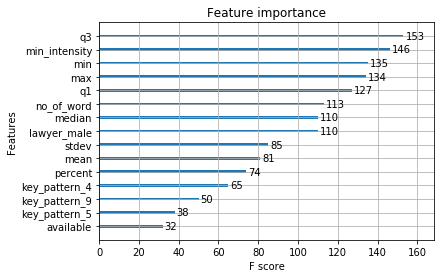

In [11]:
from xgboost import plot_importance

% matplotlib inline
from matplotlib import pyplot

plot_importance(tuned_model, max_num_features=15)
pyplot.show()

### Plot loss function

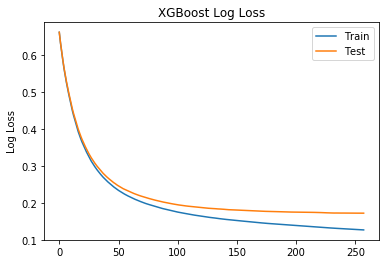

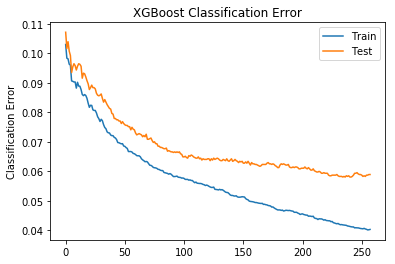

In [12]:
epochs = len(cv_result['test-logloss-mean'])
x_axis = range(0, epochs)

# Plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, cv_result['train-logloss-mean'], label='Train')
ax.plot(x_axis, cv_result['test-logloss-mean'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# Plot Classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, cv_result['train-error-mean'], label='Train')
ax.plot(x_axis, cv_result['test-error-mean'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()


In [14]:
y_pred = tuned_model.predict(xg_test)
print(len(y_pred))

bi_pred = []
filter_test = []
for i in range(len(y_pred)):
    if y_pred[i] > 0.5:
        bi_pred.append(1)
        filter_test.append(y_test.iloc[i])
    elif y_pred[i] <= 0.5:
        bi_pred.append(0)
        filter_test.append(y_test.iloc[i])

series_pred = pd.Series(bi_pred)
series_test = pd.Series(filter_test)
print(len(series_pred))
result = pd.crosstab(series_test, series_pred, rownames=["Actual"], colnames=["Predicted"])
result

1172
1172


Predicted,0,1
Actual,,
0,445,40
1,36,651


## Make Prediction on 60K Voice Clips

In [17]:
# Read the data
pre_data = pd.read_csv('60K_dataset_without_train_0813.csv')
print(pre_data.shape)

# Preprossing
acoustics = ["max", 'min', 'mean', 'median', 'q1', 'q3', 'stdev', 'min_intensity']
for item in acoustics:
    pre_data[item] = pre_data[item].apply(pd.to_numeric, errors='coerce', downcast='float')

# Prediction
X_pre = pre_data[X_train.columns]
xg_pre = xgb.DMatrix(X_pre)
y_pred = tuned_model.predict(xg_pre)

# Write to file
filename = pre_data['file_name']
pred2 = pd.DataFrame({"prob_male_alone": y_pred})

filename.reset_index(drop=True, inplace=True)
pred2.reset_index(drop=True, inplace=True)

df = pd.concat([filename, pred2], axis=1)
df.to_csv('Male_training_60K_prediction.csv', index=False)

(48834, 79)


In [17]:
pre_data_w_together_prob = pd.read_csv("All_training_60K_prediction.csv")
pred1 = pre_data_w_together_prob['training_together_prob']
male_pred1 = pred1[pre_data_w_together_prob['lawyer_male']==1]

(0, 1)

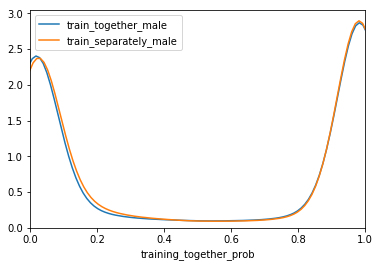

In [20]:
import seaborn as sns
sns.distplot(male_pred1, hist = False, label = 'train_together_male')
sns.distplot(pred2, hist = False, label = 'train_separately_male')
pyplot.xlim(0, 1)

In [22]:
add_separate_male = pd.merge(pre_data_w_together_prob, df, how="left", on="file_name")
separate_female = pd.read_csv("Female_training_60K_prediction.csv")
add_separate_female = pd.merge(add_separate_male, separate_female, how = "left", on="file_name")
add_separate_female.to_csv("prediction_result_Aug14.csv", index=False)

In [24]:
print(add_separate_female.shape)

(48834, 82)
